# Что такое Резнет?

ResNet, сокращение от Residual Network, — это особый тип нейронной сети, который был представлен в 2015 году Кайминг Хэ, Сянъюй Чжан, Шаоцин Рен и Цзянь Сунь в их статье «Глубокое остаточное обучение для распознавания изображений». Модели ResNet были чрезвычайно успешными.

Занял 1-е место в классификационном конкурсе ILSVRC 2015 с коэффициентом ошибок в пятерке лучших 3,57% (ансамблевая модель).

Занял 1-е место на соревнованиях ILSVRC и COCO 2015 в категориях ImageNet Detection, ImageNet локализации, Coco обнаружения и Coco сегментации.

Замена слоев VGG-16 в Faster R-CNN на ResNet-101. Они наблюдали относительное улучшение на 28%.

Эффективно обученные сети со 100 и 1000 слоями.

### Потребность в резнете

В основном для того, чтобы решить сложную проблему, мы добавляем несколько дополнительных слоев в глубокие нейронные сети, что приводит к повышению точности и производительности. Интуиция, стоящая за добавлением дополнительных слоев, заключается в том, что эти слои постепенно изучают более сложные функции. Например, в случае распознавания изображений первый уровень может научиться обнаруживать края, второй уровень может научиться определять текстуры, и аналогичным образом третий уровень может научиться обнаруживать объекты и так далее. Но было обнаружено, что для традиционной модели сверточной нейронной сети существует максимальный порог глубины. Вот график, который описывает процент ошибок в данных обучения и тестирования для 20-слойной сети и 56-уровневой сети.


#### Импортируем библиотеки

In [ ]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
import splitfolders

#### Установим начальные параметры для дальнейшей работы

In [3]:
SEED = 42

TRAIN_R = 0.6
VAL_R = 0.2
TEST_R = 0.2

IMG_HEIGHT, IMG_WIDTH = (224, 224)
BATCH_SIZE = 32

DATA_DIR_PATH = "training"
OUTPUT_DIR = "split_images"


splitfolders.ratio(DATA_DIR_PATH, OUTPUT_DIR, seed=SEED, ratio=(TRAIN_R, VAL_R, TEST_R))

Copying files: 1600 files [00:02, 542.23 files/s]


#### ImageDataGenerator - Создание пакетов данных тензорного изображения с увеличением данных в реальном времени.

In [4]:
train_data_dir = f"{OUTPUT_DIR}/train"
valid_data_dir = f"{OUTPUT_DIR}/val"
test_data_dir = f"{OUTPUT_DIR}/test"

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

### flow_from_directory :
flow_from_directory (directory): принимает путь к папке в качестве параметра, генерирует данные, которые были обновлены / нормализованы, и генерирует пакетные данные в бесконечном цикле

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical")

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical")


test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode="categorical")

Found 960 images belonging to 9 classes.
Found 320 images belonging to 9 classes.
Found 320 images belonging to 9 classes.


ResNet-50 — это сверточная нейронная сеть с глубиной 50 слоев. Можно загрузить предварительно обученную версию сети, обученную на более чем миллионе изображений из базы данных ImageNet [1]. Предварительно обученная сеть может классифицировать изображения по 1000 категориям объектов. В результате сеть изучила богатые представления функций для широкого спектра изображений. Сеть имеет входной размер изображения 224 на 224.

In [6]:
EPOCHS = 10

base_model = ResNet50(include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)

predictions = Dense(train_generator.num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"])

history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=EPOCHS)

Epoch 1/10
30/30 [==============================] - 176s 6s/step - loss: 1.2541 - acc: 0.6656 - val_loss: 0.4656 - val_acc: 0.8281
Epoch 2/10
30/30 [==============================] - 152s 5s/step - loss: 0.2813 - acc: 0.8948 - val_loss: 0.2876 - val_acc: 0.8969
Epoch 3/10
30/30 [==============================] - 156s 5s/step - loss: 0.2486 - acc: 0.9083 - val_loss: 0.2994 - val_acc: 0.9000
Epoch 4/10
30/30 [==============================] - 142s 5s/step - loss: 0.1793 - acc: 0.9427 - val_loss: 0.3227 - val_acc: 0.9031
Epoch 5/10
30/30 [==============================] - 149s 5s/step - loss: 0.0989 - acc: 0.9667 - val_loss: 0.2805 - val_acc: 0.9000
Epoch 6/10
30/30 [==============================] - 149s 5s/step - loss: 0.1170 - acc: 0.9573 - val_loss: 0.2368 - val_acc: 0.9250
Epoch 7/10
30/30 [==============================] - 152s 5s/step - loss: 0.0850 - acc: 0.9760 - val_loss: 0.2238 - val_acc: 0.9187
Epoch 8/10
30/30 [==============================] - 142s 5s/step - loss: 0.0587 - a

In [8]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


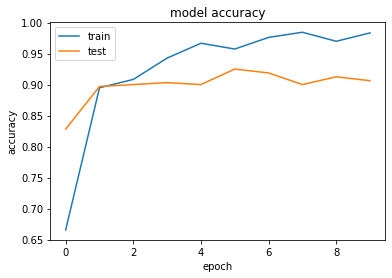

In [9]:
# обобщаем историю для точности

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

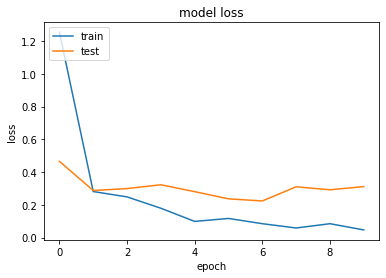

In [10]:
# суммируем историю потерь

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
model.save('clothes_data\Saved_Model\ResNet50_clothes.h5' )

test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\test accuracy:', test_acc)

320/320 - 56s - loss: 0.2360 - acc: 0.9219 - 56s/epoch - 175ms/step
	est accuracy: 0.921875


### Confusion Matrix
Визуализатор ConfusionMatrix — это ScoreVisualizer, который берет подобранный классификатор scikit-learn и набор тестовых значений X и y и возвращает отчет, показывающий, как каждый из тестовых значений спрогнозированных классов сравнивается с их фактическими классами. Исследователи данных используют Confusion Matrix, чтобы понять, какие классы легче всего спутать. Они предоставляют информацию, аналогичную той, что доступна в ClassificationReport, но вместо оценок высшего уровня они обеспечивают более глубокое понимание классификации отдельных точек данных.

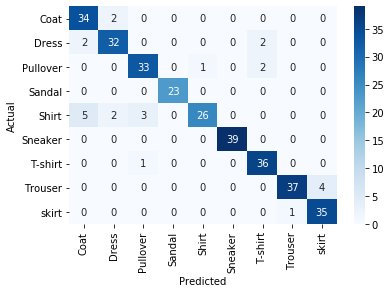

test accuracy : 92.1875


In [12]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
model = tf.keras.models.load_model("clothes_data\Saved_Model\ResNet50_clothes.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix,cmap='Blues', annot=True, fmt='d')
plt. show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

Как мы можем видеть, мы достигли довольно высокой точности (около 90 процентов), используя ResNet50 c тем же набором данных. 